# Detectron Validation

In [1]:
from nb_detectron import *
from fastai.vision import *
from detectron2.utils.visualizer import ColorMode

In [3]:
checkpoint_path = Path('/workspace/oct_ca_seg/runsaves/maskrcnn/')

In [4]:
cfg = get_cfg()

In [5]:
cfg.MODEL

CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': '', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': [], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 64, 128, 256, 512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['res4'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 1.0), 'SMOOTH_L1_BETA': 0.0, 'LOSS_WEIGHT': 1.0, 'PRE_NMS_TOPK_TRAIN': 12000, 'PRE_NMS_TOPK_TEST': 6000, 'POST_NMS_TOPK_TRAIN': 2000, 'P

In [7]:
cfg.merge_from_file(checkpoint_path/'configD2.yaml')

In [8]:
cfg.MODEL.WEIGHTS = str(checkpoint_path/'model_final.pth') #can change model_final to a checkpoint to see as well

In [9]:
predictor = DefaultPredictor(cfg)

In [10]:
projectname = 'OCT'

In [11]:
data_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = data_path/'train'
valid_path = data_path/'valid'
test_path = data_path/'test'

## Datasets

In [12]:
trainCOCO = COCO(train_path/'images/annotations.json')
validCOCO = COCO(valid_path/'images/annotations.json')
testCOCO = COCO(test_path/'images/annotations.json')

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


In [13]:
trainDetectronDataset = load_coco_json(train_path/('images/annotations.json'), train_path/'images', dataset_name=train_path.name)
validDetectronDataset = load_coco_json(valid_path/('images/annotations.json'), valid_path/'images', dataset_name=valid_path.name)
testDetectronDataset = load_coco_json(test_path/('images/annotations.json'), test_path/'images', dataset_name=test_path.name)

In [14]:
for d in [train_path, valid_path, test_path]:
    DatasetCatalog.register(projectname + d.name,
                            lambda d=d: load_coco_json(d/('images/annotations.json'), d/'images', dataset_name=d.name))  #get_dicts(d.name))#
    MetadataCatalog.get(projectname+ d.name).set(stuff_classes=["lumen"])

In [15]:
train_metadata = MetadataCatalog.get(projectname+'train')
train_metadata.stuff_classes = ['lumen']
train_metadata.thing_classes = ['lumen']
valid_metadata = MetadataCatalog.get(projectname+'valid')
valid_metadata.stuff_classes = ['lumen']
valid_metadata.thing_classes = ['lumen']
test_metadata = MetadataCatalog.get(projectname+'test')
test_metadata.stuff_classes = ['lumen']
test_metadata.thing_classes = ['lumen']

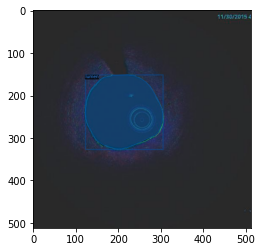

In [16]:
for d in random.sample(trainDetectronDataset, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(projectname+'train'), scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

## Results

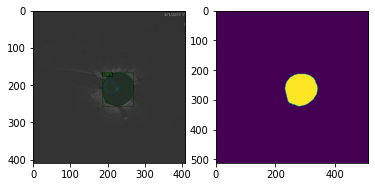

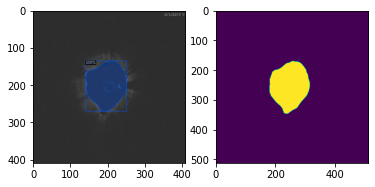

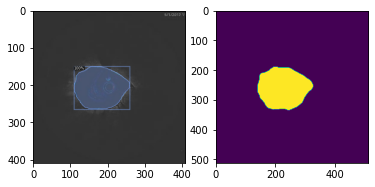

In [52]:
for d in random.sample(testDetectronDataset, 3):    
    im = cv2.imread(d["file_name"])
    #print(d.keys())
    
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=valid_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    fig, (ax1, ax2) = plt.subplots(1,2)
    image_plot = ax1.imshow(v.get_image()[:, :, ::-1])
    
    
    label_full = annsToSingleBinMask(testCOCO, d['image_id']) 
    label_plot = ax2.imshow(label_full)

##  Analysis 

In [18]:
model_parameters = filter(lambda p: p.requires_grad, predictor.model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [19]:
params

43695638

In [20]:
def save_results(results, path):
    with open(path, 'w') as output_json_file:
        json.dump(results, output_json_file, indent=4)

In [21]:
def load_results_json(results_name, checkpoint_path):
    with open(checkpoint_path/results_name, 'r') as file:
        data = json.load(file)
        return data

In [22]:
class Analysis():
    def __init__(self, predictor, validdataset, results, topThresh, checkpoint_path):
        self.predictor = predictor
        self.valid = validdataset
        self.results = results
        self.checkpoint_path = checkpoint_path
        self.topThresh = topThresh
        self.dices_zeros, self.dices = self.remove0FromMetric('dices')
    
    def processOutputsToMask(self, outputs):
        scores = outputs['instances'].scores
        if len(scores)==0: 
            return torch.zeros(outputs['instances'].image_size).unsqueeze(0).cuda()
        else:
            good_indices = [i for i,x in enumerate(outputs['instances'].scores) if x>self.topThresh]
            if not good_indices: good_indices= [torch.argmax(scores).item()]
            #good_indices = torch.tensor(good_indices, dtype=torch.long).cuda()
        #print(good_indices)
        #print(outputs['instances'].pred_masks.size())
        mask = outputs['instances'].pred_masks.clone().detach()[good_indices]
        #mask = torch.index_select(outputs['instances'].pred_masks.clone().detach(), 0, good_indices)
        mask = mask.int().sum(dim=0).unsqueeze(0).cuda()
        mask = (mask>0).float()
        return mask
    
    def remove0FromMetric(self, metric):
        zero_dict = {k:v for (k,v) in self.results[metric].items() if v==0}
        zero_dict = {k: v for k, v in sorted(zero_dict.items(), key=lambda item: item[1])}
        new_dict = {k:v for (k,v) in self.results[metric].items() if v!=0}
        new_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1])}
        print('there were ', len(zero_dict.keys()), 'zeros in the ', metric,' list.')
        return zero_dict, new_dict
    
    def histPlotMetric(self,metric, save=False):
        #metric = one of 'dices', 'sens', 'specs', 'accs' 
        zeros, actual = self.remove0FromMetric(metric)
        l_actual = list(actual.values())
        l_actual = [x for x in l_actual if x==x] # get rid of nans
        mean, std, median, max, min = np.mean(l_actual), np.std(l_actual), np.median(l_actual), np.max(l_actual), np.min(l_actual)
        print(mean, std, median, max, min)
        plt.hist(l_actual)
        if save: plt.savefig(self.checkpoint_path/(metric+'.png'))
        #return l_actual
    
    def showPrediction(self, id):
        d = validCOCO.imgs[id]
        im = cv2.imread(d["file_name"])
        print(id, Path(d["file_name"]).name)

        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                       metadata=valid_metadata, 
                       scale=0.8, 
                       instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
                      )

        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        fig, (ax1, ax2) = plt.subplots(1,2)
        image_plot = ax1.imshow(v.get_image()[:, :, ::-1])
        
        label_full = annsToSingleBinMask(validCOCO, d['image_id']) 
        dice_loss = lossdice(self.processOutputsToMask(outputs).cpu(), torch.tensor(label_full)).item()
        label_plot = ax2.imshow(label_full)
        print(dice_loss)

In [57]:
checkpoint_path = Path('/workspace/oct_ca_seg/runsaves/maskrcnn')
analysis_results = load_results_json('0.5_results.json', checkpoint_path)
anaysis_05 = Analysis(predictor, testDetectronDataset,analysis_results,0.1, checkpoint_path)

there were  0 zeros in the  dices  list.


In [89]:
torch.rand(16,3,256,256).size()

torch.Size([16, 3, 256, 256])

In [90]:
%time
predictor.model(torch.rand(16,256,256,3))

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 15.5 µs


IndexError: too many indices for tensor of dimension 3

1 0010696.jpg
0.933409571647644


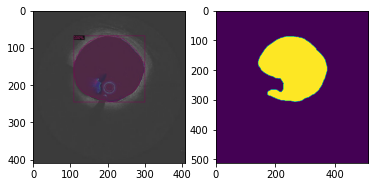

In [58]:
anaysis_05.showPrediction(1)

there were  0 zeros in the  dices  list.
0.9710825068525749 0.05311836016136551 0.9827271103858948 0.9912320375442505 0.4313693046569824


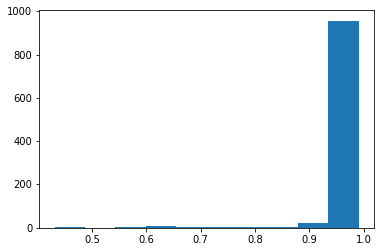

In [59]:
anaysis_05.histPlotMetric('dices')

In [64]:
checkpoint_path = Path('/workspace/oct_ca_seg/runsaves/maskrcnn')
analysis_results = load_results_json('0.7_results.json', checkpoint_path)
anaysis_07 = Analysis(predictor, validDetectronDataset,analysis_results,0.7, checkpoint_path)

there were  0 zeros in the  dices  list.


there were  0 zeros in the  dices  list.
0.9711975068739145 0.05249040855495607 0.9827271103858948 0.9912320375442505 0.4313693046569824


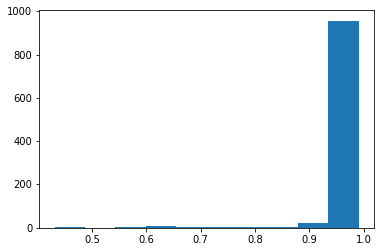

In [65]:
anaysis_07.histPlotMetric('dices')

### Validation

In [62]:
%%time
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

cfg.MODEL.WEIGHTS = os.path.join(checkpoint_path, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

coco_ev = COCOEvaluator(projectname+"test", cfg, False, output_dir=cfg.OUTPUT_DIR)
OCT_ev = OCT_Evaluator(testCOCO, 0.9)

evaluators = DatasetEvaluators([coco_ev, OCT_ev])
test_loader = build_detection_test_loader(cfg, projectname+"test")
results = inference_on_dataset(predictor.model, test_loader, evaluators)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.969
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.932
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.950
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.950
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [63]:
save_results(results, checkpoint_path/'0.9_results.json');

## Test

In [ ]:
%%time
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


cfg.MODEL.WEIGHTS = os.path.join(checkpoint_path, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)


coco_ev = COCOEvaluator(projectname+"test", cfg, False, output_dir=cfg.OUTPUT_DIR)
OCT_ev = OCT_Evaluator(testCOCO)

evaluators = DatasetEvaluators([coco_ev, OCT_ev])
val_loader = build_detection_test_loader(cfg, projectname+"test")
test_results = inference_on_dataset(predictor.model, val_loader, evaluators)